In [1]:
import json
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import random
matplotlib.style.use("ggplot")
random.seed( 30 )

In [2]:
n = "69321"
file = "data/events" + "/" + n + ".json"
with open (file, "r", encoding='utf-8-sig') as f:
	obj = json.load(f)

In [3]:
df = json_normalize(obj)

In [4]:
df = df.dropna(axis=1, how='all')

In [5]:
df['type.name'].unique()

array(['Starting XI', 'Half Start', 'Pass', 'Ball Receipt*', 'Carry',
       'Duel', 'Pressure', 'Dispossessed', 'Interception', 'Dribble',
       'Ball Recovery', 'Clearance', 'Block', 'Dribbled Past',
       'Foul Committed', 'Foul Won', 'Miscontrol', 'Goal Keeper',
       'Shield', 'Shot', 'Injury Stoppage', 'Player Off', 'Player On',
       'Referee Ball-Drop', 'Half End', 'Substitution', '50/50',
       'Tactical Shift'], dtype=object)

In [6]:
notDef = ['Starting XI','Half Start','Pass','Ball Receipt*','Carry','Pressure','Dispossessed','Dribble','Dribbled Past','Miscontrol', 'Goal Keeper',  'Shot', 'Injury Stoppage', 'Player Off', 'Player On','Referee Ball-Drop', 'Half End', 'Substitution', 'Tactical Shift']

In [7]:
df.columns

Index(['50_50.outcome.id', '50_50.outcome.name', 'ball_receipt.outcome.id',
       'ball_receipt.outcome.name', 'ball_recovery.recovery_failure',
       'carry.end_location', 'clearance.aerial_won', 'clearance.body_part.id',
       'clearance.body_part.name', 'clearance.head',
       ...
       'substitution.replacement.id', 'substitution.replacement.name',
       'tactics.formation', 'tactics.lineup', 'team.id', 'team.name',
       'timestamp', 'type.id', 'type.name', 'under_pressure'],
      dtype='object', length=116)

In [8]:
for val in notDef:
    df = df[df["type.name"] != val]

In [9]:
df['type.name'].unique()

array(['Duel', 'Interception', 'Ball Recovery', 'Clearance', 'Block',
       'Foul Committed', 'Foul Won', 'Shield', '50/50'], dtype=object)

In [10]:
us_def = df[df["team.id"] == 1214]
opp_def = df[df["team.id"] != 1214]

In [11]:
us_def = us_def.astype({"player.id": int})
opp_def = opp_def.astype({"player.id": int})

In [12]:
from scipy.spatial import ConvexHull
from matplotlib.patches import Arc
%matplotlib inline

In [14]:
x = []
y = []
xo = []
yo = []

for loc in us_def['location'].values:
    x.append(loc[0])
    y.append(loc[1])
    
for loc in opp_def['location'].values:
    xo.append(loc[0])
    yo.append(loc[1])

In [15]:
us_def['x'] = x
us_def['y'] = y

opp_def['x'] = xo
opp_def['y'] = yo

In [16]:
#us_def.to_csv('abc.csv')
us_def['position.name'].unique()

array(['Right Center Midfield', 'Left Wing', 'Left Back',
       'Left Center Back', 'Left Center Midfield', 'Right Back',
       'Center Defensive Midfield', 'Goalkeeper', 'Right Center Back',
       'Right Wing', 'Center Forward'], dtype=object)

In [17]:
pos = ['Right Center Midfield', 'Left Wing',
       'Left Center Midfield', 
       'Center Defensive Midfield', 
       'Right Wing', 'Center Forward' ]

for p in pos:
    us_def = us_def[us_def["position.name"] != p]
    opp_def = opp_def[opp_def["position.name"] != p]

In [21]:
us_def = us_def[us_def['x'] < 100]
opp_def = opp_def[opp_def['x'] < 100]

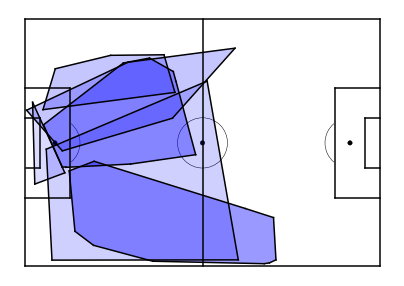

In [22]:
fig=plt.figure()
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)

#Pitch Outline & Centre Line
plt.plot([0,0],[0,90], color="black")
plt.plot([0,130],[90,90], color="black")
plt.plot([130,130],[90,0], color="black")
plt.plot([130,0],[0,0], color="black")
plt.plot([65,65],[0,90], color="black")

#Left Penalty Area
plt.plot([16.5,16.5],[65,25],color="black")
plt.plot([0,16.5],[65,65],color="black")
plt.plot([16.5,0],[25,25],color="black")

#Right Penalty Area
plt.plot([130,113.5],[65,65],color="black")
plt.plot([113.5,113.5],[65,25],color="black")
plt.plot([113.5,130],[25,25],color="black")

#Left 6-yard Box
plt.plot([0,5.5],[54,54],color="black")
plt.plot([5.5,5.5],[54,36],color="black")
plt.plot([5.5,0.5],[36,36],color="black")

#Right 6-yard Box
plt.plot([130,124.5],[54,54],color="black")
plt.plot([124.5,124.5],[54,36],color="black")
plt.plot([124.5,130],[36,36],color="black")

#Prepare Circles
centreCircle = plt.Circle((65,45),9.15,color="black",fill=False)
centreSpot = plt.Circle((65,45),0.8,color="black")
leftPenSpot = plt.Circle((11,45),0.8,color="black")
rightPenSpot = plt.Circle((119,45),0.8,color="black")

#Draw Circles
ax.add_patch(centreCircle)
ax.add_patch(centreSpot)
ax.add_patch(leftPenSpot)
ax.add_patch(rightPenSpot)

#Prepare Arcs
leftArc = Arc((11,45),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="black")
rightArc = Arc((119,45),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="black")

#Draw Arcs
ax.add_patch(leftArc)
ax.add_patch(rightArc)

#Tidy Axes
plt.axis('off')

for player in us_def['player.id'].unique():
    
    #Create a new dataframe for the player
    df = us_def[(us_def['player.id'] == player)]
    
    #Create an array of the x/y coordinate groups
    points = df[['x', 'y']].values

    #If there are enough points for a hull, create it. If there's an error, forget about it
    try:
        hull = ConvexHull(df[['x','y']])
        
    except:
        pass
    
    #If we created the hull, draw the lines and fill with 5% transparent red. If there's an error, forget about it
    try:     
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
            plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'blue', alpha=0.05)
                       
    except:
        pass
    
#Once all of the individual hulls have been created, plot them together

plt.show()
#plt.savefig('abc.png', dpi = 1000)

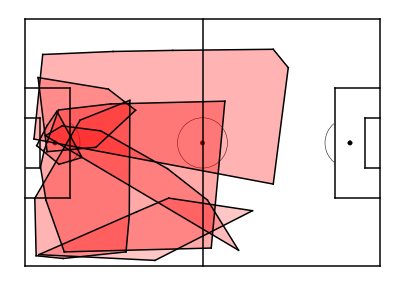

In [23]:
fig=plt.figure()
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)

#Pitch Outline & Centre Line
plt.plot([0,0],[0,90], color="black")
plt.plot([0,130],[90,90], color="black")
plt.plot([130,130],[90,0], color="black")
plt.plot([130,0],[0,0], color="black")
plt.plot([65,65],[0,90], color="black")

#Left Penalty Area
plt.plot([16.5,16.5],[65,25],color="black")
plt.plot([0,16.5],[65,65],color="black")
plt.plot([16.5,0],[25,25],color="black")

#Right Penalty Area
plt.plot([130,113.5],[65,65],color="black")
plt.plot([113.5,113.5],[65,25],color="black")
plt.plot([113.5,130],[25,25],color="black")

#Left 6-yard Box
plt.plot([0,5.5],[54,54],color="black")
plt.plot([5.5,5.5],[54,36],color="black")
plt.plot([5.5,0.5],[36,36],color="black")

#Right 6-yard Box
plt.plot([130,124.5],[54,54],color="black")
plt.plot([124.5,124.5],[54,36],color="black")
plt.plot([124.5,130],[36,36],color="black")

#Prepare Circles
centreCircle = plt.Circle((65,45),9.15,color="black",fill=False)
centreSpot = plt.Circle((65,45),0.8,color="black")
leftPenSpot = plt.Circle((11,45),0.8,color="black")
rightPenSpot = plt.Circle((119,45),0.8,color="black")

#Draw Circles
ax.add_patch(centreCircle)
ax.add_patch(centreSpot)
ax.add_patch(leftPenSpot)
ax.add_patch(rightPenSpot)

#Prepare Arcs
leftArc = Arc((11,45),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="black")
rightArc = Arc((119,45),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="black")

#Draw Arcs
ax.add_patch(leftArc)
ax.add_patch(rightArc)

#Tidy Axes
plt.axis('off')

for player in opp_def['player.id'].unique():
    
    #Create a new dataframe for the player
    df = opp_def[(opp_def['player.id'] == player)]
    
    #Create an array of the x/y coordinate groups
    points = df[['x', 'y']].values

    #If there are enough points for a hull, create it. If there's an error, forget about it
    try:
        hull = ConvexHull(df[['x','y']])
        
    except:
        pass
    
    #If we created the hull, draw the lines and fill with 5% transparent red. If there's an error, forget about it
    try:     
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
            plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'red', alpha=0.05)
                       
    except:
        pass
    
#Once all of the individual hulls have been created, plot them together

plt.show()
#plt.savefig('abc.png', dpi = 1000)